# Propulsor

> Fill in a module description here

In [ ]:
# | default_exp propulsor
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from typing import List, Tuple, Union
from dataclasses import dataclass
from scipy import optimize, interpolate
from scipy.optimize import root_scalar
from abc import ABC, abstractmethod
import os
from typing import TypeVar

In [ ]:
# | export

Numeric = TypeVar("Numeric", float, np.ndarray)


@dataclass
class PropulsorOperatingPoint:
    """Propulsor operating point data class"""

    vessel_speed_kn: Numeric
    n_rpm: Numeric
    j: Numeric
    wake_velocity_kn: Numeric
    propeller_thrust_newton: Numeric
    thrust_deduction_factor: Numeric
    resistance_newton: Numeric
    torque_newton_meter: Numeric
    efficiency_open_water: Numeric

    @property
    def shaft_power_kw(self) -> Numeric:
        """Get the shaft power in kW"""
        return self.torque_newton_meter * rps_to_rad_per_s(self.n_rpm / 60) / 1000

    @property
    def wake_fraction_factor(self) -> Numeric:
        """Get the wake fraction factor"""
        return 1 - self.wake_velocity_kn / self.vessel_speed_kn

    @property
    def efficiency_hull(self) -> Numeric:
        """Get the hull efficiency"""
        try:
            hull_efficiency = (1 - self.thrust_deduction_factor) / (
                    1 - self.wake_fraction_factor
            )
        except ZeroDivisionError:
            hull_efficiency = 0
        return hull_efficiency


@dataclass
class WakeFractionThrustDeductionFactorPoint:
    wake_fraction_factor: float
    thrust_deduction_factor: float
    vessel_speed_kn: float


@dataclass
class OpenWaterPropellerCurvePoint:
    """Open water propeller curve point data class"""

    j: float
    kt: float
    kq: float


class ReCorrection(Enum):
    ITTC78 = "ITTC78"
    Bseries = "Bseries"
    NoCorrection = "NoCorrection"


class Propulsor(ABC):
    @abstractmethod
    def get_propulsor_data_from_vessel_speed_rps(
            self, vessel_speed_kn: float, n_rps: float
    ) -> PropulsorOperatingPoint:
        pass

    @abstractmethod
    def get_propulsor_data_from_vessel_speed_thrust(
            self, vessel_speed_kn: float, thrust_resistance_newton: float
    ) -> PropulsorOperatingPoint:
        pass

In [ ]:
import numpy as np
from ship_model_lib.propulsor import (
    WakeFractionThrustDeductionFactorPoint,
    OpenWaterPropellerCurvePoint,
)

In [ ]:
# Test data:
pitch_diameter_ratio = 0.721
blade_area_ratio = 0.431
dp_diameter_propeller_m = 9.86
blade_number = 4

vessel_speed_kn = np.array([13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18])
wake_fraction = np.array(
    [0.338, 0.337, 0.336, 0.335, 0.334, 0.332, 0.329, 0.328, 0.326, 0.325, 0.322]
)
thrust_deduction = np.array(
    [0.201, 0.205, 0.209, 0.214, 0.218, 0.22, 0.223, 0.224, 0.227, 0.229, 0.233]
)
wake_factor_thrust_deduction_points = [
    WakeFractionThrustDeductionFactorPoint(
        wake_fraction_factor=wake_frac,
        thrust_deduction_factor=thrust_ded,
        vessel_speed_kn=speed,
    )
    for wake_frac, thrust_ded, speed in zip(
        wake_fraction, thrust_deduction, vessel_speed_kn
    )
]

j_array = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])
kt_array = (
        np.array(
            [5.97, 5.54, 5.08, 4.58, 4.07, 3.57, 3.08, 2.57, 2.07, 1.58, 1.08, 0.53, 0.0]
        )
        * 1e-1
)
kq_array = (
        np.array(
            [8.86, 8.26, 7.72, 7.09, 6.49, 5.90, 5.31, 4.66, 4.00, 3.32, 2.62, 1.83, 0.87]
        )
        * 1e-2
)

propeller_curve_points = [
    OpenWaterPropellerCurvePoint(j=j, kt=kt, kq=kq)
    for j, kt, kq in zip(j_array, kt_array, kq_array)
]

In [ ]:
# | export
def kn_to_m_per_s(v_kn: Numeric) -> Numeric:
    return v_kn * 0.5144


def m_per_s_to_kn(m_per_s: Numeric) -> Numeric:
    return m_per_s / 0.5144


def rps_to_rad_per_s(n_rps: Numeric) -> Numeric:
    return n_rps * 2 * np.pi

In [ ]:
# | export
class PropulsorDataOpenWater(Propulsor):
    """Propulsor defined by open water propeller data

    The open water propeller data is defined by the thrust (Kt) and torque
    coefficients (Kq) as a function of the advance ratio (J).
    """

    def __init__(
            self,
            propeller_curve_points: List[OpenWaterPropellerCurvePoint],
            dp_diameter_propeller_m: float,
            wake_thrust_reduction: List[WakeFractionThrustDeductionFactorPoint] = None,
            pitch_diameter_ratio: float = 0.7,
            rho: float = 1025,
    ):
        """Constructor of the propulsor"""
        self._j = np.array([p.j for p in propeller_curve_points])
        self._kt = np.array([p.kt for p in propeller_curve_points])
        self._kq = np.array([p.kq for p in propeller_curve_points])
        self._pod = pitch_diameter_ratio
        self._d = dp_diameter_propeller_m
        self._rho = rho
        self._interpolate_kt = interpolate.PchipInterpolator(x=self._j, y=self._kt)
        self._interpolate_kq = interpolate.PchipInterpolator(x=self._j, y=self._kq)
        # Set interpolation functions for wake thrust reduction
        if wake_thrust_reduction and len(wake_thrust_reduction) == 1:
            self._interpolate_thrust_reduction = interpolate.PchipInterpolator(
                x=np.array([0, wake_thrust_reduction[0].vessel_speed_kn]),
                y=np.ones(2) * wake_thrust_reduction[0].thrust_deduction_factor,
            )
            self._interpolate_wake_factor = interpolate.PchipInterpolator(
                x=np.array([0, wake_thrust_reduction[0].vessel_speed_kn]),
                y=np.ones(2) * wake_thrust_reduction[0].thrust_deduction_factor,
            )
        elif wake_thrust_reduction:
            speed_array = np.array([pt.vessel_speed_kn for pt in wake_thrust_reduction])
            wake_array = np.array(
                [pt.wake_fraction_factor for pt in wake_thrust_reduction]
            )
            thrust_red_array = np.array(
                [pt.thrust_deduction_factor for pt in wake_thrust_reduction]
            )
            self._interpolate_wake_factor = interpolate.PchipInterpolator(
                x=speed_array, y=wake_array
            )
            self._interpolate_thrust_reduction = interpolate.PchipInterpolator(
                x=speed_array, y=thrust_red_array
            )
        else:
            self._interpolate_thrust_reduction = None
            self._interpolate_wake_factor = None

    def get_kt(self, j: Numeric) -> Numeric:
        """Get the thrust coefficient of the propulsor

        @param j: advance ratio
        @return: thrust coefficient
        """
        return self._interpolate_kt(j)

    def get_kq(self, j: Numeric) -> Numeric:
        """Get the torque coefficient of the propulsor

        @param j: advance ratio
        @return: torque coefficient
        """
        return self._interpolate_kq(j)

    def get_efficiency_open_water(self, j: Numeric) -> Numeric:
        """Get the efficiency of the propulsor in open water

        @param j: advance ratio
        @return: efficiency
        """
        return self.get_kt(j) * j / self.get_kq(j) / 2 / np.pi

    def plot_open_water_curves(self):
        """Plot the open water curves of the propulsor"""
        efficiency_ref = self._kt * self._j / self._kq / 2 / np.pi
        j = np.linspace(0, self._j.max(), 100)
        efficiency = self.get_efficiency_open_water(j)
        plt.plot(
            self._j,
            self._kt,
            "o",
            self._j,
            10 * self._kq,
            "x",
            self._j,
            efficiency_ref,
            "*",
        )  # plot openwater data
        plt.plot(
            j, self.get_kt(j), j, 10 * self.get_kq(j), j, efficiency
        )  # plot interpolated data
        plt.xlabel("Advance Ratio J")
        plt.ylabel("KT, 10*KQ, Efficiency")
        plt.title("Open water Curves")
        plt.legend(["KT", "KQ", "\eta"])
        plt.show()
        print(
            "\n Maximum efficiency is {:.2f} at J = {:.2f}".format(
                max(efficiency), j[np.argmax(efficiency)]
            )
        )

    def _get_wake_velocity_m_per_s(self, vessel_speed_kn: float) -> float:
        """Get the wake velocity of the propulsor

        @param vessel_speed_kn: vessel speed in knots
        @return: wake velocity in m/s
        """
        if self._interpolate_wake_factor is None:
            return kn_to_m_per_s(vessel_speed_kn)
        return kn_to_m_per_s(
            vessel_speed_kn * (1 - self._interpolate_wake_factor(vessel_speed_kn))
        )

    def _get_thrust_reduction(self, vessel_speed_kn: float) -> float:
        return (
            0.0
            if self._interpolate_thrust_reduction is None
            else self._interpolate_thrust_reduction(vessel_speed_kn)
        )

    def _get_advance_ratio(self, n_rps: float, vessel_speed_kn: float) -> float:
        """Get the advance ratio of the propulsor

        @param n_rps: propeller speed in revolutions per second
        @param vessel_speed_kn: vessel speed in knots
        @return: advance ratio
        """
        wake_velocity_m_per_s = self._get_wake_velocity_m_per_s(vessel_speed_kn)
        return wake_velocity_m_per_s / (n_rps * self._d)

    def get_thrust_newton(self, n_rps: float, vessel_speed_kn: float) -> float:
        """Get the thrust of the propulsor

        @param n_rps: propeller speed in revolutions per second
        @param vessel_speed_kn: vessel speed in knots
        @return: thrust in Newton
        """
        j = self._get_advance_ratio(n_rps=n_rps, vessel_speed_kn=vessel_speed_kn)
        return self.get_kt(j) * self._rho * n_rps ** 2 * self._d ** 4

    def get_thrust_reduced(self, n_rps: float, vessel_speed_kn: float) -> float:
        """Get the thrust of the propulsor

        @param n_rps: propeller speed in revolutions per second
        @param vessel_speed_kn: vessel speed in knots
        @return: thrust in Newton
        """
        thrust = self.get_thrust_newton(n_rps=n_rps, vessel_speed_kn=vessel_speed_kn)
        return thrust * (1 - self._get_thrust_reduction(vessel_speed_kn))

    def get_torque_newton_meter(self, n_rps: float, vessel_speed_kn: float) -> float:
        """Get the torque of the propulsor

        @param n_rps: propeller speed in revolutions per second
        @param vessel_speed_kn: vessel speed in knots
        @return: torque in Newton meter
        """
        j = self._get_advance_ratio(n_rps=n_rps, vessel_speed_kn=vessel_speed_kn)
        return self.get_kq(j) * self._rho * n_rps ** 2 * self._d ** 5

    def get_propulsor_data_from_vessel_speed_rps(
            self,
            vessel_speed_kn: Numeric,
            n_rps: Numeric,
    ) -> PropulsorOperatingPoint:
        """Get the propulsor data from the vessel speed and propeller speed"""
        vessel_speed_kn = np.atleast_1d(vessel_speed_kn)
        n_rps = np.atleast_1d(n_rps)
        if len(vessel_speed_kn) != len(n_rps):
            raise ValueError(
                "vessel_speed_kn and n_rps must be of same length or scalar"
            )
        j = np.zeros_like(vessel_speed_kn)
        thrust_newton = np.zeros_like(vessel_speed_kn)
        thrust_reduced_newton = np.zeros_like(vessel_speed_kn)
        torque_newton_meter = np.zeros_like(vessel_speed_kn)
        efficiency_open_water = np.zeros_like(vessel_speed_kn)
        valid_indices = np.where(np.bitwise_and(vessel_speed_kn > 0, n_rps > 0))
        j[valid_indices] = self._get_advance_ratio(
            n_rps=n_rps[valid_indices], vessel_speed_kn=vessel_speed_kn[valid_indices]
        )
        thrust_newton[valid_indices] = self.get_thrust_newton(
            n_rps=n_rps[valid_indices], vessel_speed_kn=vessel_speed_kn[valid_indices]
        )
        thrust_reduced_newton[valid_indices] = self.get_thrust_reduced(
            n_rps=n_rps[valid_indices], vessel_speed_kn=vessel_speed_kn[valid_indices]
        )
        torque_newton_meter[valid_indices] = self.get_torque_newton_meter(
            n_rps=n_rps[valid_indices], vessel_speed_kn=vessel_speed_kn[valid_indices]
        )
        efficiency_open_water[valid_indices] = self.get_efficiency_open_water(
            j[valid_indices]
        )
        return PropulsorOperatingPoint(
            vessel_speed_kn=vessel_speed_kn,
            n_rpm=n_rps * 60,
            j=j,
            wake_velocity_kn=m_per_s_to_kn(
                self._get_wake_velocity_m_per_s(vessel_speed_kn)
            ),
            propeller_thrust_newton=thrust_newton,
            thrust_deduction_factor=self._get_thrust_reduction(vessel_speed_kn),
            resistance_newton=thrust_reduced_newton,
            torque_newton_meter=torque_newton_meter,
            efficiency_open_water=efficiency_open_water,
        )

    def _function_to_solve_for_n_rps(
            self, n_rps: float, vessel_speed_kn: float, thrust_resistance_newton: float
    ):
        """Function to solve for n_rps"""
        return (
                self.get_thrust_reduced(n_rps=n_rps, vessel_speed_kn=vessel_speed_kn)
                - thrust_resistance_newton
        )

    def _get_initial_guess_for_n_rps(self, vessel_speed_kn: float) -> float:
        """Get an initial guess for the n_rps"""
        return kn_to_m_per_s(vessel_speed_kn) / (0.5 * self._j.max() * self._d)

    def get_propulsor_data_from_vessel_speed_thrust(
            self, vessel_speed_kn: Numeric, thrust_resistance_newton: Numeric
    ) -> PropulsorOperatingPoint:
        """Get the propulsor data from the vessel speed and thrust"""
        vessel_speed_kn = np.atleast_1d(vessel_speed_kn)
        thrust_resistance_newton = np.atleast_1d(thrust_resistance_newton)
        n_rps = []
        for speed, thrust in zip(vessel_speed_kn, thrust_resistance_newton):
            if speed == 0 or thrust <= 0:
                n_rps.append(0.0)
                continue
            initial_n_rps = self._get_initial_guess_for_n_rps(vessel_speed_kn=speed)
            sol = root_scalar(
                f=self._function_to_solve_for_n_rps,
                x0=initial_n_rps,
                x1=initial_n_rps * 1.1,
                args=(speed, thrust),
            )
            if sol.converged:
                n_rps.append(sol.root)
            else:
                raise ValueError(
                    f"Could not find a solution for the speed({speed} kn) and thrust({thrust} N)"
                )
        n_rps = np.array(n_rps)
        return self.get_propulsor_data_from_vessel_speed_rps(
            vessel_speed_kn=vessel_speed_kn, n_rps=n_rps
        )

In [ ]:
import random
import pytest
from dataclasses import fields

import numpy as np
from ship_model_lib.propulsor import PropulsorDataOpenWater, kn_to_m_per_s

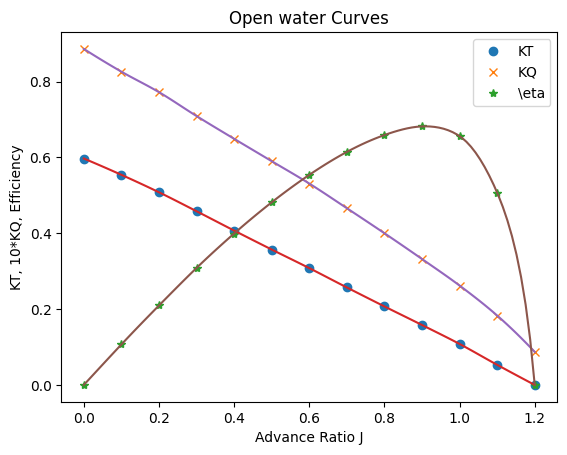


 Maximum efficiency is 0.68 at J = 0.91


In [ ]:
propulsor = PropulsorDataOpenWater(
    propeller_curve_points=propeller_curve_points,
    dp_diameter_propeller_m=4.5,
    pitch_diameter_ratio=1.2,
    wake_thrust_reduction=wake_factor_thrust_deduction_points,
)
propulsor.plot_open_water_curves()

In [ ]:
# Test get_propulsor_data_from_vessel_speed_rps
j_value = (
        random.random() * (propulsor._j.max() - propulsor._j.min()) + propulsor._j.min()
)
speed_kn = random.random() * 20
n_rps = kn_to_m_per_s(speed_kn) / (j_value * propulsor._d)
propulsion_point = propulsor.get_propulsor_data_from_vessel_speed_rps(
    vessel_speed_kn=speed_kn, n_rps=n_rps
)
eff_hull = (propulsion_point.resistance_newton * speed_kn) / (
        propulsion_point.propeller_thrust_newton * propulsion_point.wake_velocity_kn
)
eff_open_water = (
                         propulsion_point.propeller_thrust_newton
                         * kn_to_m_per_s(propulsion_point.wake_velocity_kn)
                 ) / (propulsion_point.shaft_power_kw * 1000)
print(propulsion_point)
assert propulsion_point.efficiency_hull == pytest.approx(eff_hull, rel=1e-4)
assert propulsion_point.efficiency_open_water == pytest.approx(eff_open_water, rel=1e-4)

# Test the inverse
propulsion_point_inv = propulsor.get_propulsor_data_from_vessel_speed_thrust(
    vessel_speed_kn=speed_kn,
    thrust_resistance_newton=propulsion_point.resistance_newton,
)
for field in fields(propulsion_point_inv):
    assert getattr(propulsion_point_inv, field.name)[0] == pytest.approx(
        getattr(propulsion_point, field.name), rel=1e-4
    )

PropulsorOperatingPoint(vessel_speed_kn=array([9.95838561]), n_rpm=array([1122.87914987]), j=array([0.03989738]), wake_velocity_kn=array([6.53187214]), propeller_thrust_newton=array([85411119.98151435]), thrust_deduction_factor=array([0.17666708]), resistance_newton=array([70321786.39696977]), torque_newton_meter=array([57058200.88092308]), efficiency_open_water=array([0.04277336]))


In [ ]:
# | export
class PropulsorDataBseries(PropulsorDataOpenWater):
    """Class for propulsor data from B-series polynomials

    The class calculates KT, KQ and Efficiency for given P/D, Blade Area Ratio,
    diameter, Number of blades, Reynolds number and surface roughness kp and use
    open water curve to estimate the propulsion thrust and torque.

    Wageningen B-series polynomials have been used to obtain openwater curves.
    e.g. b_Series_openwater(PoD=0.721, EAR=0.431, D=9.86, Z=4, Re=2e6, kp=30e-6,
    Re_correction='ITTC78', plotflag=0)

    Range of different parameters in B series data is as follows:
    PoD : P/D                   0.5  to  1.4
    EAR : expanded area ratio   0.3  to  1.05
    Z   : number of blades      2    to    7
    Re  : reynolds number       2e6  to  2e9
    kp  : roughness of full scale propeller in meters (not less than 30e-6)
    Re_correction: 'ITTC78' or 'Bseries'

    ITTC78 method can take into account the effect of surface roughness
    value of kp not used in case of Bseries Reynolds number correction
    Default: ITTC78 with kp = 30e-6
    Reynolds number correction is applied only if it is greater than 2x10^6.

    Reference: Bernitsas, M. M., Ray, D., & Kinley, P. (1981).
    KT, KQ and efficiency curves for the Wageningen B-series propellers.

    Doc: B_Series, ITTC78
    """

    def __init__(
            self,
            pd_pitch_diameter_ratio: float,
            ear_blade_area_ratio: float,
            dp_diameter_propeller_m: float,
            z_blade_number: int,
            wake_thrust_reduction: WakeFractionThrustDeductionFactorPoint = None,
            rho: float = 1025,
            re: float = 2e6,
            kp: float = 30e-6,
            re_correction: ReCorrection = ReCorrection.ITTC78,
    ):
        self._pod = pd_pitch_diameter_ratio
        self._ear = ear_blade_area_ratio
        self._d = dp_diameter_propeller_m
        self._z = z_blade_number
        self._re = re
        self._kp = kp
        self._rho = rho
        self._re_correction = re_correction

        try:
            file_path = os.path.join(
                os.path.dirname(os.path.realpath(__file__)),
                os.pardir,
                "dependencies",
                "B_series_coefficients.npy",
            )
            self._coefficients = np.load(file_path)
        except (NameError, NotADirectoryError, FileNotFoundError):
            self._coefficients = np.load("./dependencies/B_series_coefficients.npy")

        # load coefficients for wageningen B series
        self._multKT = (
                self._coefficients[0]
                * (self._pod ** self._coefficients[1])
                * (self._ear ** self._coefficients[2])
                * (self._z ** self._coefficients[3])
        )
        self._multKQ = (
                self._coefficients[4]
                * (self._pod ** self._coefficients[5])
                * (self._ear ** self._coefficients[6])
                * (self._z ** self._coefficients[7])
        )
        if self._re_correction == "Bseries" and self._re > 2e6:
            # apply Reynolds number correction id Re is greater than 2e6
            try:
                file_path = os.path.join(
                    os.path.dirname(os.path.realpath(__file__)),
                    os.pardir,
                    "dependencies",
                    "Re_correction.npy",
                )
                [self._dKT, self._dKQ] = np.load(file_path)
            except (NameError, NotADirectoryError, FileNotFoundError):
                [self._dKT, self._dKQ] = np.load("./dependencies/Re_correction.npy")
        propeller_curve_points = self._generate_kt_kq_curve()
        super().__init__(
            propeller_curve_points=propeller_curve_points,
            dp_diameter_propeller_m=dp_diameter_propeller_m,
            wake_thrust_reduction=wake_thrust_reduction,
            pitch_diameter_ratio=pd_pitch_diameter_ratio,
            rho=rho,
        )

    def _generate_kt_kq_curve(
            self, j_step: float = 0.01
    ) -> List[OpenWaterPropellerCurvePoint]:
        """Generate KT and KQ curves for given propeller parameters"""
        j = 0.0
        kt = 1.0
        kq = 1.0
        result = []
        while kt > 0:
            kt = self._get_kt_bseries(j)[0]
            kq = self._get_kq_bseries(j)[0]
            if self._re_correction.name == "Bseries":
                kt, kq = self._re_correction_bseries(KT=kt, KQ=kq, j=j)
            elif self._re_correction.name == "ITTC78":
                kt, kq = self._re_correction_ittc78(KT=kt, KQ=kq)
            else:
                print("No Reynolds Number correction selected.")
            result.append(OpenWaterPropellerCurvePoint(j=j, kt=kt, kq=kq))
            j += j_step
        return result

    def _get_kt_bseries(self, j_value: Numeric) -> Numeric:
        if isinstance(j_value, float):
            j_value = np.array([j_value])
        kt = np.array(
            [(sum((j ** self._coefficients[8]) * self._multKT)) for j in j_value]
        )
        return kt

    def _get_kq_bseries(self, j_value: Numeric) -> Numeric:
        if isinstance(j_value, float):
            j_value = np.array([j_value])
        kq = np.array(
            [sum((j ** self._coefficients[9]) * self._multKQ) for j in j_value]
        )
        return kq

    def _re_correction_ittc78(self, KT, KQ):
        # doc: ITTC78
        t = (0.0216 - 0.0015 * self._z) * self._d
        # blade thickness at 0.7R for B series propellers
        c = (
            2.168 / (self._z / self._ear) * self._d
            if self._z == 3
            else 2.144 / (self._z / self._ear) * self._d
        )
        # cord at 0.7R for B series propellers
        CD_model = (
                2
                * (1 + 2 * t / c)
                * (0.044 / self._re ** (1 / 6) - 5 / self._re ** (2 / 3))
        )
        # drag coefficient of model propeller
        CD_ship = 2 * (1 + 2 * t / c) * (1.89 + 1.62 * np.log(c / self._kp)) ** -2.5
        # drag coefficient of full scale propeller
        dCD = CD_model - CD_ship  # difference in drag coefficients
        KT -= -dCD * 0.3 * self._pod * c * self._z / self._d  # adjust KT and KQ
        KQ -= dCD * 0.25 * c * self._z / self._d
        return KT, KQ

    def _re_correction_bseries(self, KT, KQ, j):
        if self._re > 2e6:  # apply Reynolds number correction id Re is greater than 2e6
            KT += (
                    self._dKT[0]
                    + self._dKT[1] * self._ear * j ** 2
                    + self._dKT[2] * self._ear * self._pod * j
                    + self._dKT[3] * (np.log(self._re) - 0.301) ** 2 * self._ear * j ** 2
                    + self._dKT[4] * (np.log(self._re) - 0.301) * self._pod ** 6 * j * 2
                    + self._dKT[5] * (np.log(self._re) - 0.301) ** 2 * self._pod ** 6 * j ** 2
                    + self._dKT[6]
                    * (np.log(self._re) - 0.301) ** 2
                    * self._z
                    * self._ear
                    * j ** 2
                    + self._dKT[7]
                    * (np.log(self._re) - 0.301)
                    * self._z
                    * self._ear
                    * self._pod
                    * j
                    + self._dKT[8]
                    * (np.log(self._re) - 0.301)
                    * self._z ** 2
                    * self._ear
                    * self._pod ** 3
                    * j
            )

            KQ += (
                    self._dKQ[0]
                    + self._dKQ[1] * self._pod
                    + self._dKQ[2] * self._z * self._pod ** 6
                    + self._dKQ[3] * self._ear ** 2
                    + self._dKQ[4] * (np.log(self._re) - 0.301) * self._pod
                    + self._dKQ[5] * (np.log(self._re) - 0.301) * self._pod ** 2
                    + self._dKQ[6] * (np.log(self._re) - 0.301) ** 2 * self._pod ** 2
                    + self._dKQ[7] * (np.log(self._re) - 0.301) * self._z * self._ear * j ** 2
                    + self._dKQ[8]
                    * (np.log(self._re) - 0.301) ** 2
                    * self._z
                    * self._ear
                    * self._pod
                    * j
                    + self._dKQ[9] * (np.log(self._re) - 0.301) * self._z * self._pod ** 6
                    + self._dKQ[10]
                    * (np.log(self._re) - 0.301) ** 2
                    * self._z
                    * self._pod ** 6
                    + self._dKQ[11] * (np.log(self._re) - 0.301) * self._ear ** 2
                    + self._dKQ[12] * (np.log(self._re) - 0.301) ** 2 * self._ear ** 2
            )

        return KT, KQ

In [ ]:
from ship_model_lib.propulsor import PropulsorDataBseries, ReCorrection

In [ ]:
propulsor_bseries = PropulsorDataBseries(
    pd_pitch_diameter_ratio=pitch_diameter_ratio,
    ear_blade_area_ratio=blade_area_ratio,
    dp_diameter_propeller_m=dp_diameter_propeller_m,
    z_blade_number=blade_number,
    re=2e6,
    kp=30e-6,
    wake_thrust_reduction=wake_factor_thrust_deduction_points,
    re_correction=ReCorrection.ITTC78,
)
propulsor_bseries.plot_open_water_curves()

In [ ]:
# Test get_propulsor_data_from_vessel_speed_rps
j_value = (
        random.random() * (propulsor._j.max() - propulsor._j.min()) + propulsor._j.min()
)
speed_kn = random.random() * 20
n_rps = kn_to_m_per_s(speed_kn) / (j_value * propulsor._d)
propulsion_point = propulsor.get_propulsor_data_from_vessel_speed_rps(
    vessel_speed_kn=speed_kn, n_rps=n_rps
)
eff_hull = (propulsion_point.resistance_newton * speed_kn) / (
        propulsion_point.propeller_thrust_newton * propulsion_point.wake_velocity_kn
)
eff_open_water = (
                         propulsion_point.propeller_thrust_newton
                         * kn_to_m_per_s(propulsion_point.wake_velocity_kn)
                 ) / (propulsion_point.shaft_power_kw * 1000)
print(propulsion_point)
assert propulsion_point.efficiency_hull == pytest.approx(eff_hull, rel=1e-4)
assert propulsion_point.efficiency_open_water == pytest.approx(eff_open_water, rel=1e-4)

# Test the inverse
propulsion_point_inv = propulsor.get_propulsor_data_from_vessel_speed_thrust(
    vessel_speed_kn=speed_kn,
    thrust_resistance_newton=propulsion_point.resistance_newton,
)
for field in fields(propulsion_point_inv):
    assert getattr(propulsion_point_inv, field.name)[0] == pytest.approx(
        getattr(propulsion_point, field.name), rel=1e-4
    )

In [ ]:
# | export
class PropulsorDataScalar(Propulsor):
    def __init__(self, efficiency):
        self.efficiency = efficiency

    def get_propulsor_data_from_vessel_speed_rps(
            self, n_rps: float, vessel_speed_kn: float
    ) -> PropulsorOperatingPoint:
        """Not implemented for PropulsorDataScalar"""
        raise NotImplementedError("Not implemented for PropulsorDataScalar")

    def get_propulsor_data_from_vessel_speed_thrust(
            self, vessel_speed_kn: float, thrust_resistance_newton: float
    ) -> PropulsorOperatingPoint:
        if np.isscalar(vessel_speed_kn):
            n_rps = 1 if vessel_speed_kn > 0.0 else 0.0
        else:
            n_rps = np.zeros_like(vessel_speed_kn)
            n_rps[vessel_speed_kn > 0.0] = 1.0
        vessel_speed_m_per_s = kn_to_m_per_s(vessel_speed_kn)
        shaft_power_kw = (
                thrust_resistance_newton * vessel_speed_m_per_s / self.efficiency / 1000
        )
        if np.isscalar(n_rps):
            torque_newton_meter = (
                shaft_power_kw / (n_rps * 2 * np.pi) * 1000 if n_rps > 0.0 else 0.0
            )
        else:
            torque_newton_meter = np.zeros_like(n_rps)
            torque_newton_meter[n_rps > 0.0] = (
                    shaft_power_kw[n_rps > 0.0] / (n_rps[n_rps > 0.0] * 2 * np.pi) * 1000
            )
        return PropulsorOperatingPoint(
            vessel_speed_kn=vessel_speed_kn,
            n_rpm=n_rps * 60,
            j=0,
            wake_velocity_kn=vessel_speed_kn,
            propeller_thrust_newton=thrust_resistance_newton,
            thrust_deduction_factor=0.0,
            resistance_newton=thrust_resistance_newton,
            torque_newton_meter=torque_newton_meter,
            efficiency_open_water=self.efficiency,
        )

    def get_propulsor_thrust_from_shaft_power(
            self, shaft_power_kw, vessel_speed_kn: float
    ) -> PropulsorOperatingPoint:
        vessel_speed_m_per_s = kn_to_m_per_s(vessel_speed_kn)
        thrust_newton = self.efficiency * shaft_power_kw / vessel_speed_m_per_s * 1000
        n_rps = 1
        torque_newton_meter = shaft_power_kw / rps_to_rad_per_s(n_rps) * 1000
        return PropulsorOperatingPoint(
            vessel_speed_kn=vessel_speed_kn,
            n_rpm=n_rps * 60,
            j=0,
            wake_velocity_kn=vessel_speed_kn,
            propeller_thrust_newton=thrust_newton,
            thrust_deduction_factor=0.0,
            resistance_newton=thrust_newton,
            torque_newton_meter=torque_newton_meter,
            shaft_power_kw=shaft_power_kw,
            efficiency_open_water=self.efficiency,
        )

In [ ]:
import numpy as np
from scipy import interpolate
from ship_model_lib.propulsor import (
    WakeFractionThrustDeductionFactorPoint,
    PropulsorDataOpenWater,
    OpenWaterPropellerCurvePoint,
)

Vessel data

In [ ]:
# | hide
data_set_vessel_speed_kn = np.array(
    [13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18]
)
data_set_wake_factor = np.array(
    [0.338, 0.337, 0.336, 0.335, 0.334, 0.332, 0.329, 0.328, 0.326, 0.325, 0.322]
)
data_set_thrust_reduction = np.array(
    [0.201, 0.205, 0.209, 0.214, 0.218, 0.22, 0.223, 0.224, 0.227, 0.229, 0.233]
)
data_set_total_resistance_kilo_newton = np.array(
    [546.3, 586.7, 626.9, 666.1, 707.3, 751.4, 799.4, 854.4, 921.3, 1001.2, 1098]
)

Open propeller data

In [ ]:
# | hide
data_set_propeller_diameter_pd_m = 7
data_set_j = np.array([x / 20 for x in range(0, 19)])
data_set_kt = (
        np.array(
            [
                4.109,
                3.905,
                3.699,
                3.491,
                3.279,
                3.064,
                2.847,
                2.629,
                2.412,
                2.194,
                1.977,
                1.758,
                1.536,
                1.311,
                1.078,
                0.838,
                0.587,
                0.33,
                0.068,
            ]
        )
        * 1e-1
)
data_set_kq = (
        np.array(
            [
                4.828,
                4.607,
                4.387,
                4.168,
                3.949,
                3.729,
                3.509,
                3.29,
                3.071,
                2.851,
                2.629,
                2.403,
                2.17,
                1.926,
                1.668,
                1.394,
                1.103,
                0.797,
                0.0484,
            ]
        )
        * 1e-2
)

Results

In [ ]:
# | hide
data_set_n_rpm = [74.1, 77, 79.9, 82.7, 85.6, 88.5, 91.6, 94.7, 98.2, 101.9, 106.3]
data_set_power_kw = [
    4770,
    5327,
    5923,
    6552,
    7232,
    7966,
    8797,
    9719,
    10883,
    12250,
    13982,
]

Testing

In [ ]:
# | hide
# Check the input data are of the same length
assert len(data_set_vessel_speed_kn) == len(
    data_set_wake_factor
), f"Length {len(data_set_wake_factor)} is not equal to what is expected {len(data_set_vessel_speed_kn)}"
assert len(data_set_vessel_speed_kn) == len(
    data_set_thrust_reduction
), f"Length {len(data_set_thrust_reduction)} is not equal to what is expected {len(data_set_vessel_speed_kn)}"
assert len(data_set_vessel_speed_kn) == len(
    data_set_total_resistance_kilo_newton
), f"Length {len(data_set_total_resistance_kilo_newton)} is not equal to what is expected {len(data_set_vessel_speed_kn)}"
assert len(data_set_j) == len(
    data_set_kt
), f"Length {len(data_set_kt)} is not equal to what is expected {len(data_set_j)}"
assert len(data_set_j) == len(
    data_set_kq
), f"Length {len(data_set_kq)} is not equal what is expected {len(data_set_j)}"
assert len(data_set_vessel_speed_kn) == len(
    data_set_n_rpm
), f"Length {len(data_set_n_rpm)} is not equal to what is expected {len(data_set_vessel_speed_kn)}"
assert len(data_set_vessel_speed_kn) == len(
    data_set_power_kw
), f"Length {len(data_set_power_kw)} is not equal what is expected {len(data_set_vessel_speed_kn)}"

In [ ]:
# | hide
propeller_curve_points = [
    OpenWaterPropellerCurvePoint(j=j, kt=kt, kq=kq)
    for j, kt, kq in zip(data_set_j, data_set_kt, data_set_kq)
]
wake_factor_thrust_deduction_points = [
    WakeFractionThrustDeductionFactorPoint(
        vessel_speed_kn=vessel_speed_kn,
        wake_fraction_factor=wake_factor,
        thrust_deduction_factor=thrust_reduction,
    )
    for vessel_speed_kn, wake_factor, thrust_reduction in zip(
        data_set_vessel_speed_kn, data_set_wake_factor, data_set_thrust_reduction
    )
]

data_set_propeller = PropulsorDataOpenWater(
    propeller_curve_points=propeller_curve_points,
    dp_diameter_propeller_m=data_set_propeller_diameter_pd_m,
    wake_thrust_reduction=wake_factor_thrust_deduction_points,
)
rtol = 0.075
interpolate_wake_factor = interpolate.PchipInterpolator(
    data_set_vessel_speed_kn, data_set_wake_factor
)
interpolate_thrust_reduction = interpolate.PchipInterpolator(
    data_set_vessel_speed_kn, data_set_thrust_reduction
)
data_set_propeller_performance = (
    data_set_propeller.get_propulsor_data_from_vessel_speed_thrust(
        vessel_speed_kn=data_set_vessel_speed_kn,
        thrust_resistance_newton=data_set_total_resistance_kilo_newton * 1000,
    )
)

assert np.allclose(
    data_set_propeller_performance.n_rpm / data_set_n_rpm, 1, rtol=rtol
), (
    f"Propeller data {data_set_propeller_performance.n_rpm}, "
    f"Calculated propeller rpm {data_set_propeller_performance.n_rpm} "
    f"is not equal to the expected {data_set_n_rpm} rpm"
)
assert np.allclose(
    data_set_propeller_performance.shaft_power_kw / data_set_power_kw, 1, rtol=rtol
), (
    f"Propeller data {data_set_propeller_performance}, "
    f"Calculated propeller shaft power kW {data_set_propeller_performance.shaft_power_kw} "
    f"is not equal to the expected {data_set_power_kw} kW"
)
assert np.allclose(
    data_set_propeller_performance.resistance_newton
    / (data_set_total_resistance_kilo_newton * 1000),
    1,
    rtol=rtol,
), (
    f"Propeller data {data_set_propeller_performance}, "
    f"Calculated propeller thrust newton {data_set_propeller_performance.resistance_newton} "
    f"is not equal to the expected {data_set_total_resistance_kilo_newton * 1000} newton"
)

In [ ]:
# test for get_propulsor_data_from_vessel_speed_thrust